<a href="https://colab.research.google.com/github/ykato27/Time-Series-Deep-Learning/blob/main/4_1_3_RNN%E3%83%A2%E3%83%87%E3%83%AB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNモデル

               入力系列--- TimeRNN --- TimeAffine --- 出力系列

というニューラルネットワークを作り，学習を行います．

RNN Model

We create a neural network as

              Input Series --- TimeRNN --- TimeAffine --- Output Series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

シグモイド関数の読み込み

Loading the sigmoid function

In [2]:
def sigmoid(x):
  x = -709*(x <= -709)+709*(x >= 709) + x*(x>-709) *(x<709) #オーバーフロー対策
  return 1/(1+np.exp(-x))

### 最適化法クラスの読み込み：SGD と Adam

以前に実装したものと基本的に同じですが，パラメータの格納形式が辞書からリストに変更されています．

Loading Optimization Method Classes: SGD and Adam

Basically the same as the previous implementation, but the parameter storage format is changed from a dictionary to a list.



In [3]:

class SGD:
  '''
  確率的勾配降下法（Stochastic Gradient Descent）
  '''
  def __init__(self, lr=0.01):
    self.lr = lr
      
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]


class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None
      
  def update(self, params, grads):  
    if self.m is None:
      self.m, self.v = [], []
      for param in params:
        self.m.append(np.zeros_like(param))
        self.v.append(np.zeros_like(param))
      
    self.iter += 1
    lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

    for i in range(len(params)):
      self.m[i][:] += (1 - self.beta1) * (grads[i] - self.m[i])
      self.v[i][:] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
      
      params[i][:] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#### アファイン層クラスとその時間方向への展開

アファイン層も時間方向へパラメータをコピーして同じ変換を施しますが，入力 `x_time` を reshape することで効率的に計算します．

The class of the affine layer and its expansion in the time direction

The same transformation is applied to the affine layer by copying the parameters in the time direction, but it is computed efficiently by reshaping the input `x_time`.


In [4]:
class Affine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = None
    self.x = None

  def forward(self, x):
    W, b = self.params
    out = np.dot(x, W) + b
    self.x = x
    return out

  def backward(self, dout):
    W, b = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    db = np.sum(dout, axis=0)
    self.grads = [dW, db]
    return dx

class TimeAffine:
  '''
  W:  (H,O)
  b:  (O,)
  入力 x:(N, T, H) を (N*T, H) に変換してから (N*T, H) (H, O) + (O,)= (N*T, O) -> (N,T,O) 
  '''
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = None 
    self.layer = None

  def forward(self, x):
    N, T, H = x.shape

    # アファインレイヤを生成
    self.layer = Affine(*self.params) # * はカッコを外す *[W, b] = W, b
    x = x.reshape(N*T, -1)            #(N*T, H)
    out = self.layer.forward(x)       #(N*T, O)
    return out.reshape(N, T, -1)      #(N, T, O)

  def backward(self, dout):
    N, T, O = dout.shape
    dout = dout.reshape(N*T, -1)      #(N*T, O)
    dx = self.layer.backward(dout)    #(N*T, H)
    dx = dx.reshape(N,T,-1)           #(N, T, H)
      
    # 勾配を格納 
    self.grads = self.layer.grads
    return dx

### RNN層クラス

前のノートブックと同じものです．

RNN layer class

The same as the previous notebook.

In [5]:
#@title
class RNN:
  def __init__(self, Wx, Wh, b):
    '''
    Wx : 入力xにかかる重み        # (I,H)型       
    Wh : １時刻前のhにかかる重み  # (H,H)
    b : バイアス                  # (h,)
    '''
    self.params = [Wx, Wh, b]
    
    # 勾配のリスト
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    '''
    x      : 時刻 t の入力             # (N,I)型
    h_prev : 時刻 t-1 の中間層の出力   # (N,H)
    '''
    Wx, Wh, b = self.params

    a = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h = np.tanh(a)

    # 値の一時保存
    self.cache = (x, h_prev, h)
    return h

  def backward(self, dh):
    '''
    逆伝播計算
    '''
    Wx, Wh, b = self.params
    x, h_prev, h = self.cache

    # h = np.tanh(a) での逆伝播
    da = dh * (1 - h ** 2)
    
    # a = np.dot(h_prev, Wh) + np.dot(x, Wx) + b での逆伝播
    # 重みパラメータの勾配
    dWx = np.dot(x.T, da)
    dWh = np.dot(h_prev.T, da)
    db = np.sum(da, axis=0)

    self.grads = [dWx, dWh, db]

    # 入力に渡す勾配
    dh_prev = np.dot(da, Wh.T)
    dx = np.dot(da, Wx.T)       

    return dx, dh_prev


### TimeRNN層クラス

前のノートブックと同じものです．

TimeRNN layer class

The same as the previous notebook.

In [6]:

class TimeRNN:        
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]  # (I,H), (H,H), (H,)
    self.grads = None
    self.layers = None        

  def forward(self, x_time, h=None): 
    '''
    入力
    x_time  : 入力列
    h       : 中間状態の初期値
    出力
    h_time  : 出力列
    h       : 最後の出力
    '''
    Wx, Wh, b = self.params
    N, T, I = x_time.shape
    H = Wh.shape[0]

    if h is None: h = np.zeros((N,H))  # if h == None としてしまうと，h が配列のときにエラーになる
    self.h = h

    self.layers = []

    # h_time は中間層の出力hを時間方向につなげたもの
    h_time = np.zeros((N, T, H))
    
    # 時刻tについて順次計算する
    for t in range(T):
      # RNNレイヤを定義する
      layer = RNN(*self.params) # *[Wx, Wh, b] = Wx, Wh, b 
      self.layers.append(layer)

      # 時刻tでの計算
      self.h = layer.forward(x_time[:, t, :], self.h)
      
      # 中間層の出力hをh_timeに代入する
      h_time[:, t, :] = self.h

    return h_time, self.h #最後の時刻の中間層も出力する

  def backward(self, dh_time, dh=0): #dh,は中間層の逆伝播
    Wx, Wh, b = self.params
    N, T, H = dh_time.shape
    I = Wx.shape[0]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 後で足し算をするので作っておく

    # 前の層に渡すための出力
    dx_time = np.zeros((N, T, I))
    
    # 時間について逆順に計算
    for t in reversed(range(T)):
      layer = self.layers[t] # LSTMレイヤーの呼び出し

      # 出力層への勾配dh_timeと次の時刻の中間層への勾配dhを足したものを逆伝播
      dx, dh = layer.backward(dh_time[:, t, :] + dh)
      dx_time[:, t, :] = dx
      
      self.grads[0] += layer.grads[0]
      self.grads[1] += layer.grads[1]
      self.grads[2] += layer.grads[2]

    return dx_time, dh

## モデルの定義 Definition of the model

               入力系列--- TimeRNN --- TimeAffine --- 出力系列


という回帰問題のときのモデルを作ってみましょう．回帰問題の出力層では活性化関数は用いません．

Let's create a model as

               Input Series --- TimeRNN --- TimeAffine --- Output Series

for a regression problem
 In the output layer of the regression problem, we do not use the activation function.

In [7]:
class RNN_model:
  def __init__(self, input_size, hidden_size, output_size):
    I, H, O = input_size, hidden_size, output_size
    self.I, self.H, self.O = I, H, O

    # RNNのパラメータ
    rnn_Wx = np.random.randn(I, H) / np.sqrt(I)   # He の初期値の真似 
    rnn_Wh = np.random.randn(H, H) / np.sqrt(H)   # He の初期値の真似 
    rnn_b = np.zeros(H)
    
    # アファイン層のパラメータ
    affine_W = np.random.randn(H, O) / np.sqrt(H)
    affine_b = np.zeros(O)

    self.params = [rnn_Wx, rnn_Wh, rnn_b, affine_W, affine_b]

    # レイヤの生成
    self.trnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b) # RNNレイヤ
    self.taffine = TimeAffine(affine_W, affine_b) # Affineレイヤ
  

  def predict(self, x):
    # 損失レイヤ以外の全てのレイヤについて計算する
    x, _ = self.trnn.forward(x)
    x = self.taffine.forward(x)
    return x
  
  def forward(self, x, t):
    # 損失レイヤ以外の全てのレイヤについて計算する
    self.pred = self.predict(x)
    self.t = t 
    
    # 損失レイヤを計算する
    N = x.shape[0]
    loss = ((self.pred - t)**2).sum()/(2*N)
    return loss

  def backward(self):
    # 損失レイヤの逆伝播計算
    N = self.pred.shape[0]
    dout = (self.pred - self.t)/N
    
    # 損失レイヤ以外の逆伝播計算
    dout = self.taffine.backward(dout)
    dout, _ = self.trnn.backward(dout)
    self.grads = self.trnn.grads + self.taffine.grads
    return dout

## 簡単な問題で学習 Learning with a Simple Problem

以下のようなデータで一期先を予想するという問題を学習させてみます．


Let's try to learn the problem of predicting one term ahead with the following data.

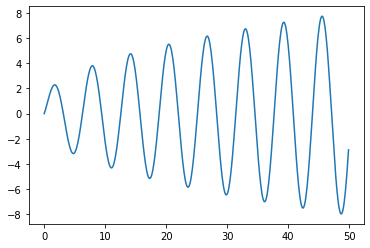

In [8]:
ar = np.arange(0,50,0.1) 
series = np.sin(ar) * (1+ ar**0.5 )

import matplotlib.pyplot as plt

plt.plot(ar, series) 

* 0から399番目までを `x_train` (400, 1)型
* 全体を `x_full` (500, 1)型

とする

We set
* 0 to 399th: `x_train` of shape (400, 1)
* the whole: `x_full`  of shape (500, 1)

In [9]:
x_train = series[:400].reshape(-1,1)
x_full = series.reshape(-1,1)

In [10]:
# ハイパーパラメータの設定

batch_size = 30 # バッチサイズ
hidden_size = 100 # RNNレイヤのノード数
time_size = 20  # ウィンドウサイズ
input_size = 1
output_size = 1
lr = 0.001 # 学習率
epochs = 500 # エポックス数

In [11]:
np.random.seed(0)

xs = x_train[:-1]  # 入力. 1時刻先を予測するので最後のデータは使わない
ts = x_train[1:]   # 出力（教師ラベル）. 1時刻先を予測するので最初のデータは使わない

# モデルの生成
model = RNN_model(1, hidden_size, 1)

In [12]:
# 最適化手法の定義
optimizer = Adam(lr=lr)

# 学習時に使用する変数
data_size = len(xs)
max_iters = max(data_size // (batch_size * time_size),1) # 1エポックで計算する回数
total_loss = 0
loss_count = 0
train_loss_list = []
test_loss_list = []

# 学習 
for epoch in range(epochs):
    for m in range(max_iters):
        # ミニバッチの各サンプルの読み込み開始位置を計算
        offsets = [np.random.choice(data_size-time_size) for i in range(batch_size)]
        # ミニバッチを生成
        batch_x = np.zeros((batch_size, time_size,input_size))
        batch_t = np.zeros((batch_size, time_size,input_size))
        for i, offset in enumerate(offsets):
            batch_x[i] = xs[offset: offset+ time_size]  #time_size分の長さの部分列            
            batch_t[i] = ts[offset: offset+ time_size]  #time_size分の長さの部分列
        
        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t) # 順伝播計算
        model.backward() # 逆伝播計算
        optimizer.update(model.params, model.grads) # パラメータの更新
        total_loss += loss # ロスの追加
        loss_count += 1
    
    if epoch % 10 == 0:
        # 訓練期間の平均損失の算出
        ave_loss = total_loss / loss_count
        train_loss_list.append(ave_loss)

        total_loss, loss_count = 0, 0
      
        # テスト期間の平均損失の計算
        xs_test = x_full[100-time_size:-1]
        ts_test = x_full[1+100-time_size:]
        data_test_size = len(xs_test)
        batch_test_size = data_test_size - time_size

        # ミニバッチを生成
        batch_test_x = np.zeros((batch_test_size, time_size, input_size))
        batch_test_t = np.zeros((batch_test_size, time_size, input_size))

        for i in range(batch_test_size):
            batch_test_x[i] = xs_test[i:i+time_size]
            batch_test_t[i] = ts_test[i:i+time_size]
    
        # 平均lossを追加
        test_loss = model.forward(batch_test_x, batch_test_t)
        test_loss_list.append(test_loss)

        print('| epoch %d | train loss %.5f | test loss %.5f'% (epoch, ave_loss, test_loss))

      

| epoch 0 | train loss 173.78696 | test loss 213.45889
| epoch 10 | train loss 107.40818 | test loss 101.95842
| epoch 20 | train loss 44.15513 | test loss 51.39184
| epoch 30 | train loss 21.94487 | test loss 28.67998
| epoch 40 | train loss 12.51189 | test loss 17.01003
| epoch 50 | train loss 7.43620 | test loss 11.93804
| epoch 60 | train loss 4.98928 | test loss 9.30615
| epoch 70 | train loss 4.08989 | test loss 7.69299
| epoch 80 | train loss 3.11326 | test loss 6.51685
| epoch 90 | train loss 2.76172 | test loss 5.64227
| epoch 100 | train loss 2.39304 | test loss 4.90908
| epoch 110 | train loss 2.14827 | test loss 4.29180
| epoch 120 | train loss 1.78169 | test loss 3.82868
| epoch 130 | train loss 1.47209 | test loss 3.45679
| epoch 140 | train loss 1.31649 | test loss 3.17568
| epoch 150 | train loss 1.29169 | test loss 2.94513
| epoch 160 | train loss 1.11105 | test loss 2.76027
| epoch 170 | train loss 1.14454 | test loss 2.59128
| epoch 180 | train loss 1.10526 | test lo

### 全期間に渡って1期先を予測 

Forecast one term ahead over the entire period

(500,) (500,)


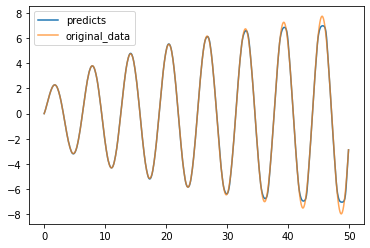

In [13]:
xs = x_full[:-1]#.reshape(-1,1)  # 入力. 1時刻先を予測するので、最後のデータは使わない

predicts = np.zeros(len(x_full))
predicts[:time_size] = x_full[:time_size, 0]

for t in range(time_size, len(x_full)):
  x_window = xs[t-time_size : t].reshape(1,time_size,1)
  # 一つ先の時間を予測する
  x_window_next = model.predict(x_window)
  # 最後の期の予測値を記録
  predicts[t] = x_window_next[0,-1,0]

print(ar.shape, predicts.shape)
plt.plot(ar,predicts, label = 'predicts')
plt.plot(ar,series, label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()

### 学習データだけを使って未来を予測する

実際には未来のデータは全く使えないので，自分で予測したデータを使って入力系列を時間方向に一つずつずらしていかなければなりません．最後の100期を予測してみましょう．

Predicting the future using only training data

Since we can't actually use the future data at all, we have to shift the input series one by one in the time direction using our own forecasted data. Let's try to predict the last 100 periods.


(500,) (100,)


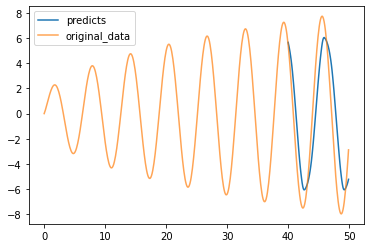

In [14]:
predicts = np.zeros(len(x_full)-len(x_train))                   #予測値の記録

#学習データの最後から始める
x_window = x_train[-time_size:].reshape(1,time_size,1)

for t in range( len(x_full)-len(x_train)):
  # 一つ先の時間を予測する
  x_window_new = model.predict(x_window)
  
  # 最後の期の予測値を記録
  predicts[t] = x_window_new[0,-1,0]

  # 答えが分かっている範囲はそちらに修正してから次の時刻に進む
  x_window_new[0, 0: time_size - 1, 0] = x_window[0, 1: time_size, 0]  
  
  x_window = x_window_new

print(ar.shape, predicts.shape)
plt.plot(ar[len(x_train):],predicts, label = 'predicts')
plt.plot(ar,series, label = 'original_data', alpha = 0.7)
plt.legend()
plt.show()
